<a href="https://colab.research.google.com/github/faiz-aljohani/Arabic-App-Review-Classification/blob/main/ICS472_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part-B [65 points]:
 Multiclass and Multilabel App Review Classification

In [1]:
!pip install transformers[torch]
!pip install farasapy
!pip install pyarabic
!pip install arabert
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
!pip install gensim

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

import keras
from keras import layers, losses, optimizers, metrics
from gensim.models import Word2Vec
from transformers import AutoConfig, BertForSequenceClassification, AutoTokenizer,AutoModelForSequenceClassification, BertModel
from transformers.data.processors import SingleSentenceClassificationProcessor
from transformers import Trainer , TrainingArguments

import nltk
from nltk import tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
dataset = pd.read_csv("https://raw.githubusercontent.com/faiz-aljohani/Arabic-App-Review-Classification/main/AppReview-Multilabel.csv")

In [5]:
dataset

,review,bug_report,improvement_request,rating,others
0,يبيله تصليحات كثير,High,Medium,Low,No
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,No,Medium,Medium,Low
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,No,High,Low,No
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,No,No,High,No
4,تبين م لي ي تم ل يب,No,No,Low,High
...,...,...,...,...,...
2895,بكل حياديه وتجرد انقل تجربتي التطبيق جميل جدا ...,Medium,Medium,Medium,No
2896,مررة صار معفن مدري الا بالقوة بيدخلنا موقعهم ه...,Medium,No,Medium,No
2897,لابد من تطويره ليستفاد منو الجميع,No,High,Low,No
2898,تطبيق اكثر من رائع ومجهود مبارك ،ننتظر المزيد ...,No,Low,High,No


## Split the dataset train/val/test...
70-30 Train TestVal. Take 50% of TestVal data as validation set.
Use seed 777 for partitioning.

### binary labels

In [6]:
def binary_label(label):
    if label in ['High','Medium','Low', 1]:
        return 1
    else:
        return 0

def pies_plot(columns, dataset):
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))
    for i, column in enumerate(columns):
        ax = axes[i // 2, i % 2]
        ax.set_title(column)
        ax.pie(dataset[column].value_counts(), labels=dataset[column].unique().tolist(), autopct='%1.1f%%')
    plt.tight_layout()
    plt.show()

In [7]:
dataset['bug_report'] = dataset['bug_report'].apply(binary_label)
dataset['improvement_request'] = dataset['improvement_request'].apply(binary_label)
dataset['rating'] = dataset['rating'].apply(binary_label)
dataset['others'] = dataset['others'].apply(binary_label)

### split

In [8]:
X = dataset.iloc[:,0].to_numpy()
y = dataset.iloc[:,1:].to_numpy()

In [9]:
train_sentences, testval_sentences, train_labels, testval_labels = train_test_split(X, y, test_size=0.3, random_state=777)
val_sentences, test_sentences, val_labels, test_labels = train_test_split(testval_sentences, testval_labels, test_size=0.5, random_state=777)

## Dataset analysis and report on important statistics.


In [10]:
dataset.head()

,review,bug_report,improvement_request,rating,others
0,يبيله تصليحات كثير,1,1,1,0
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,0,1,1,1
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,0,1,1,0
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,0,0,1,0
4,تبين م لي ي تم ل يب,0,0,1,1


In [11]:
display(dataset['bug_report'].value_counts())
display(dataset['improvement_request'].value_counts())
display(dataset['rating'].value_counts())
display(dataset['others'].value_counts())

bug_report
0    1736
1    1164
Name: count, dtype: int64

improvement_request
0    1797
1    1103
Name: count, dtype: int64

rating
1    1971
0     929
Name: count, dtype: int64

others
0    2080
1     820
Name: count, dtype: int64

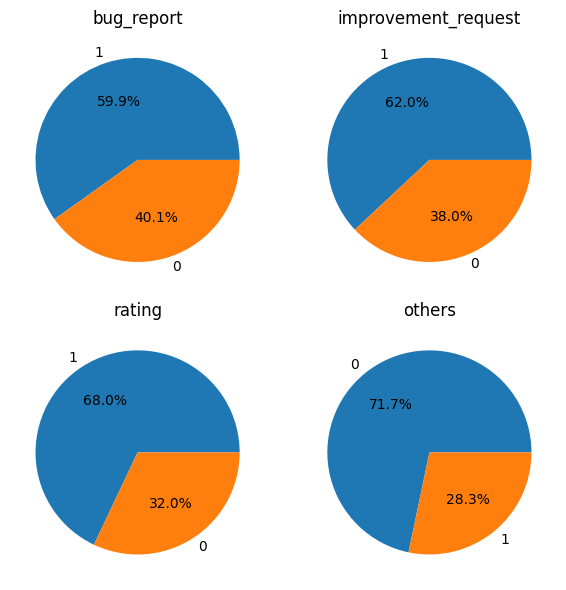

In [12]:
columns = ['bug_report', 'improvement_request', 'rating', 'others']
pies_plot(columns, dataset)

1. character count
2. word count
3. max sentence's character and word count
4. mean word length
5. mean sentence length

In [13]:
dataset['char_count'] = dataset['review'].str.len()
dataset['word_count'] = dataset['review'].str.split().str.len()
display(dataset.head())

,review,bug_report,improvement_request,rating,others,char_count,word_count
0,يبيله تصليحات كثير,1,1,1,0,18,3
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,0,1,1,1,33,6
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,0,1,1,0,76,13
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,0,0,1,0,45,8
4,تبين م لي ي تم ل يب,0,0,1,1,19,7


In [14]:
sortedDataset = dataset.sort_values('char_count', ascending=False)

sortedDataset.head()

,review,bug_report,improvement_request,rating,others,char_count,word_count
902,من فضلك أعد المحاولة\nمن فضلك أعد المحاولة\nمن...,0,0,0,1,3023,576
87,أكثر من مليار تحميل.... لكن فيه عيوب العيب الأ...,1,1,1,0,500,89
369,العبة جميلة جدا جدا جداجدا جديد جدا حمام الدار...,0,0,1,1,500,100
170,غير متقولوش لعائشة اذا كان علابالي راح نبعتلكم...,0,0,0,1,500,100
1562,جميل جداً ورائع لكن احس في بعض العيوب الليالي ...,1,1,1,1,499,93


In [15]:
dataset['mean_word_length'] = dataset['review'].map(lambda r: np.mean([len(word) for word in r.split()]))
dataset['mean_sent_length'] = dataset['review'].map(lambda r: np.mean([len(sent) for sent in tokenize.sent_tokenize(r)]))
dataset.head()

,review,bug_report,improvement_request,rating,others,char_count,word_count,mean_word_length,mean_sent_length
0,يبيله تصليحات كثير,1,1,1,0,18,3,5.333333,18.0
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,0,1,1,1,33,6,4.666667,33.0
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,0,1,1,0,76,13,4.923077,76.0
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,0,0,1,0,45,8,4.750000,45.0
4,تبين م لي ي تم ل يب,0,0,1,1,19,7,1.857143,19.0


# Preprocessing

In [16]:
import re

sample = [
    'ماتحملت ابدددددا ونا دفعت الفلوس',
    'ألسلام عليكم في الناس كلب',
    'الََعبة جميلة جدا جدا جداجدا جديد جدا حمام الدار...',
    'ييييي السال',
    'ااا لللل ععع',
    'مما ننا ككا'
]

def custom_preprocessing(sentences):
  sentences_proccesed = []
  for sentence in sentences:
    # Delete جميع الحركات
    sentence = re.sub(r'[\u064B-\u0652]', '', sentence)

    # Delete تحويل (أ, إ) الى ا
    sentence = re.sub(r'[أإ]', 'ا', sentence)

    # Delete حروف الجر, كان واخواتها
    sentence = re.sub(r'\b(فى|في|على|من|الى|كان|لكن)\b', ' ', sentence)

    # Replace ة الى ه
    sentence = re.sub(r'ة', r'ه', sentence)

    # Delete التعريف
    sentence = re.sub(r'\bال', '', sentence)

    # Delete الحرف المكرر اكثر من مرتين بالتوالي
    sentence = re.sub(r'(.)\1{2,}', r'\1\1', sentence)

    # Replace كل حرف يتكرر مرتين الى حرف واحد ما عدا الميم
    sentence = re.sub(r'(?!م|ن)(.)\1', r'\1', sentence)

    # Delete اي حرف لحاله
    sentence = re.sub(r'\b\w\b', '', sentence)

    # Delete اي كلمة اطول من 16 حرف
    sentence = ' '.join(word for word in sentence.split() if len(word) <= 16)

    # Delete اي علامة تتكرر مره وحده بس
    sentence = re.sub(r'([^\w\s])\1', '', sentence)

    sentences_proccesed.append(sentence)

  return sentences_proccesed

processed_samples = custom_preprocessing(sample)
print(processed_samples)

['ماتحملت ابدا ونا دفعت فلوس', 'سلام عليكم ناس كلب', 'عبه جميله جدا جدا جداجدا جديد جدا حمام دار.', 'سال', '', 'مما ننا كا']


In [17]:
df = pd.DataFrame({'Original Sentences': train_sentences, 'Processed Sentences': custom_preprocessing(train_sentences)})

df['proccesed word count'] = df['Processed Sentences'].str.split().apply(len)
df['word count'] = df['Original Sentences'].str.split().apply(len)

df = df.sort_values(by='proccesed word count', ascending=False)

In [18]:
display(df.head(30))

,Original Sentences,Processed Sentences,proccesed word count,word count
1363,من فضلك أعد المحاولة\nمن فضلك أعد المحاولة\nمن...,فضلك اعد محاوله فضلك اعد محاوله فضلك اعد محاول...,432,576
1683,انا كويس الحمد والشكر على كل شيء شي من برا بس ...,انا كويس حمد والشكر كل شيء شي برا بس مو كل شي ...,95,106
192,غير متقولوش لعائشة اذا كان علابالي راح نبعتلكم...,غير متقولوش لعائشه اذا علابالي راح نبعتلكم تصو...,86,100
83,بكل حياديه وتجرد انقل تجربتي التطبيق جميل جدا ...,بكل حياديه وتجرد انقل تجربتي تطبيق جميل جدا جد...,85,92
85,جميل جداً ورائع لكن احس في بعض العيوب الليالي ...,جميل جدا ورائع احس بعض عيوب ليالي بيعلق معي كث...,84,93
289,كل ما افتح مقطع يوتيوب يطلع اعلان\nكل ما افتح ...,كل ما افتح مقطع يوتيوب يطلع اعلان كل ما افتح م...,81,84
924,نصابين ، لاحدا يشتري من المتجر ، بالآخر خسران ...,نصابين ، لاحدا يشتري متجر ، بالآخر خسران قد ما...,79,85
1591,العبة جميلة جدا جدا جداجدا جديد جدا حمام الدار...,عبه جميله جدا جدا جداجدا جديد جدا حمام دار اور...,78,100
1953,والله فرحنا كثيراً بتطبيق مطبعة الملك فهد لكن ...,واله فرحنا كثيرا بتطبيق مطبعه ملك فهد لاسف به ...,77,92
1302,اعزائي الزملاء : بما اني احد منسوبي الصحة ، فه...,اعزائي زملاء : بما اني احد منسوبي صحه ، فهذا ت...,73,76


## Tokenizing

In [19]:
def word_tokenize(docs):
  return [nltk.word_tokenize(doc) for doc in docs]

train_sentences_tokenized = word_tokenize(custom_preprocessing(train_sentences))
val_sentences_tokenized = word_tokenize(custom_preprocessing(val_sentences))
test_sentences_tokenized = word_tokenize(custom_preprocessing(test_sentences))

In [20]:
vocab = set([word for sublist in train_sentences_tokenized for word in sublist])
print(" Number of unique vocab: ", len(vocab))

 Number of unique vocab:  7862


9324 unique vocab without pre-processing

# Models : (Random method will have 25%)

## BERT


### prepare data

In [42]:
import pandas as pd

# For training data
train_df = pd.DataFrame({
    'text': train_sentences,
    'bug_report': train_labels[:, 0],
    'improvement_request': train_labels[:, 1],
    'rating': train_labels[:, 2],
    'others': train_labels[:, 3],
})

# For validation data
val_df = pd.DataFrame({
    'text': val_sentences,
    'bug_report': val_labels[:, 0],
    'improvement_request': val_labels[:, 1],
    'rating': val_labels[:, 2],
    'others': val_labels[:, 3],
})

# For testing data
test_df = pd.DataFrame({
    'text': test_sentences,
    'bug_report': test_labels[:, 0],
    'improvement_request': test_labels[:, 1],
    'rating': test_labels[:, 2],
    'others': test_labels[:, 3],
})


In [43]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [44]:
labels = [label for label in train_dataset.features.keys() if label not in ['text']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels

['bug_report', 'improvement_request', 'rating', 'others']

In [53]:
MAX_SEQ_LENGTH = max([len(seq) for seq in train_dataset['text']])
print("Max sequence's length: ", MAX_SEQ_LENGTH)

Max sequence's length:  3023


### Bert tokenizing


In [60]:

model_name = 'aubmindlab/bert-base-arabert'#"google-bert/bert-base-multilingual-uncased"#
num_labels = 4

In [95]:

from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_data(examples):
  # take a batch of texts
#   examples["text"] = word_tokenize(custom_preprocessing(examples["text"]))

  text = examples["text"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()

  return encoding

### Encoding

In [96]:
train_dataset[0]['text']

'جميله انصح الجميع بتنزيلها واووووو ..'

In [97]:
train_encoded_dataset = train_dataset.map(preprocess_data, batched=True)
val_encoded_dataset = val_dataset.map(preprocess_data, batched=True)
test_encoded_dataset = test_dataset.map(preprocess_data, batched=True)

Map:   0%|          | 0/2030 [00:00<?, ? examples/s]

Map:   0%|          | 0/435 [00:00<?, ? examples/s]

Map:   0%|          | 0/435 [00:00<?, ? examples/s]

In [98]:
train_encoded_dataset[0]['text']


'جميله انصح الجميع بتنزيلها واووووو ..'

In [99]:
example = train_encoded_dataset[0]
print(example.keys())

dict_keys(['text', 'bug_report', 'improvement_request', 'rating', 'others', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [100]:
tokenizer.decode(example['input_ids'])

'[CLS] جميله انصح الجميع بتنزيلها واووووو.. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [101]:
example['labels']

[0.0, 0.0, 1.0, 0.0]

In [102]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

['rating']

In [103]:
train_encoded_dataset.set_format("torch")
val_encoded_dataset.set_format("torch")
test_encoded_dataset.set_format("torch")

### Build model


In [104]:
# config = AutoConfig.from_pretrained(model_name,num_labels=num_labels, output_attentions=True,problem_type="multi_label_classification")
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=num_labels,
                                                           problem_type="multi_label_classification",
                                                           id2label=id2label,
                                                           label2id=label2id)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training


In [105]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch

# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

In [113]:
batch_size = 8
metric_name = "accuracy"
task = "multilabel-classification"

args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    # label_names=["bug_report","improvement_request","rating","others" ]
)

In [114]:
print(type(train_dataset[0]["text"]))
print(len(train_dataset))
max_text_length = 0
for sample in train_dataset:
    max_text_length = max(max_text_length, len(sample['text']))

print("Maximum text length:", max_text_length)

<class 'str'>
2030
Maximum text length: 3023


In [115]:
#verify
train_encoded_dataset[0]['labels'].type()

'torch.FloatTensor'

In [116]:
train_encoded_dataset[0]['input_ids'].shape

torch.Size([128])

In [117]:
outputs = model(input_ids=train_encoded_dataset['input_ids'][0].unsqueeze(0), labels=train_encoded_dataset[0]['labels'].unsqueeze(0))
outputs

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [118]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_encoded_dataset,
    eval_dataset=val_encoded_dataset,
    tokenizer=tokenizer,  # for padding
    compute_metrics=compute_metrics
)

In [119]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,No log,0.489156,0.715160,0.751314,0.393103
2,0.483300,0.440813,0.768717,0.795447,0.455172
3,0.483300,0.447560,0.765957,0.792478,0.441379
4,0.277400,0.463248,0.774151,0.797807,0.445977
5,0.277400,0.476430,0.770957,0.796110,0.452874


TrainOutput(global_step=1270, training_loss=0.3411815493125615, metrics={'train_runtime': 357.1034, 'train_samples_per_second': 28.423, 'train_steps_per_second': 3.556, 'total_flos': 667656291993600.0, 'train_loss': 0.3411815493125615, 'epoch': 5.0})

### Testing ???

In [126]:
trainer.evaluate(test_encoded_dataset)

{'eval_loss': 0.41350096464157104,
 'eval_f1': 0.7837837837837838,
 'eval_roc_auc': 0.8105018993511951,
 'eval_accuracy': 0.4689655172413793,
 'eval_runtime': 3.6448,
 'eval_samples_per_second': 119.348,
 'eval_steps_per_second': 15.09,
 'epoch': 5.0}

In [123]:
text = "افضل تطبيق استخدمته"

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)

In [124]:
logits = outputs.logits
logits.shape

torch.Size([1, 4])

In [125]:
# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1
# turn predicted id's into actual label names
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print(predicted_labels)

['rating']


## Proper hyper-parameter tuning based on the validation set

## Classification analysis and possible improvements.


## Final results on the test set.